In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites, find_eps_cut
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [4]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [5]:
ENSEMBLE = 'Coarse-1'
RATIO    = 'RA1'
MOMENTUM = '100'

SMSLIST  = ['1S','RW']

In [6]:
# Correlation matrix specifics
DIAG   = False
BLOCK  = False
SCALE  = True
SHRINK = True

In [7]:
# Specifics of the analysis
TMIN    = 2
NSTATES = 1
WPRIORS = True
JKFIT   = False

In the following we look for requisites for the ratio calculation

In [8]:
requisites = ratio_prerequisites(
    ens      = ENSEMBLE,
    ratio    = RATIO,
    mom      = MOMENTUM,
    readfrom = DATA_2PT,
    jk       = JKFIT
)

requisites

{'E0': 1.099096240996636,
 'm0': 1.0806205264210942,
 'Z0': {'1S': 2.2140008675524436, 'd': 0.20463708845828885},
 'Zpar': None,
 'Zbot': {'1S': 2.0953049517063236, 'd': 0.2084797387999871},
 'wrecoil': 1.0171900293589244}

Here we initialize the master object that contains a ratio at given momentum for a given ensemble

In [9]:
io = RatioIO(ENSEMBLE,RATIO,MOMENTUM,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ENSEMBLE],
    smearing  = SMSLIST,
    readfrom  = DATA_2PT,
    **requisites
)

In [10]:
trange = (TMIN, robj.Ta-TMIN-1)

In [11]:
trange

(2, 9)

Here we elaborate the optimal $\epsilon$ cut for correlation matrix

In [12]:
cov_specs = dict(
    diag   = DIAG  ,
    block  = BLOCK ,
    scale  = SCALE ,
    shrink = SHRINK,
    cutsvd = find_eps_cut(robj,trange)
)

cov_specs

{'diag': False, 'block': False, 'scale': True, 'shrink': True, 'cutsvd': 1e-12}

Here we compute fit priors

In [13]:
dE_src = phys_energy_priors(ENSEMBLE,'Dst',MOMENTUM,NSTATES,readfrom=DATA_2PT)
dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,MOMENTUM,NSTATES,readfrom=DATA_2PT)

x,ydata = robj.format(trange,flatten=True)
f_0    = gv.gvar(np.mean(ydata).mean,0.1)
# f_0    = gv.gvar(np.mean(ydata).mean,np.mean(ydata).sdev*3.)

pr = robj.priors(NSTATES, K=f_0, dE_src=dE_src, dE_snk=dE_snk)

pr

{'ratio': [0.00004(10000)],
 'dE_src': [-1.4(1.0)],
 'dE_snk': [-0.8(1.0)],
 'A_1S': [0 ± 1.0],
 'B_1S': [0 ± 1.0],
 'A_RW': [0 ± 1.0],
 'B_RW': [0 ± 1.0]}

Here we perform the fit

In [14]:
fit = robj.fit(
    Nstates = NSTATES,
    trange  = trange,
    priors  = pr,
    verbose = False,
    **cov_specs,
)

res = robj.fit_result(
    Nexc   = NSTATES,
    trange = trange,
    verbose = True,
    priors = pr 
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
# ---------- 1+1 fit in (2, 9) for ratio: ZRA1 of ens: Coarse-1 for mom: 000 --------------
Least Square Fit:
  chi2/dof [dof] = 0.19 [16]    Q = 1    logGBF = 51.297

Parameters:
        ratio 0   -0.823 (26)     [ -0.84 (10) ]  
       dE_src 0    -1.09 (88)     [ -1.3 (1.0) ]  
       dE_snk 0    -1.31 (91)     [ -1.1 (1.0) ]  
         A_1S 0    0.026 (36)     [    0 ± 1.0 ]  
         B_1S 0    0.067 (72)     [    0 ± 1.0 ]  
         A_RW 0   -0.021 (47)     [    0 ± 1.0 ]  
         B_RW 0     0.12 (11)     [    0 ± 1.0 ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 14/1.2)
  fitter = scipy_least_squares    method = trf

# red chi2      = 3.06
# chi2_exp      = 13.75
# chi2/chi_exp  = 0.22
# p-value    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


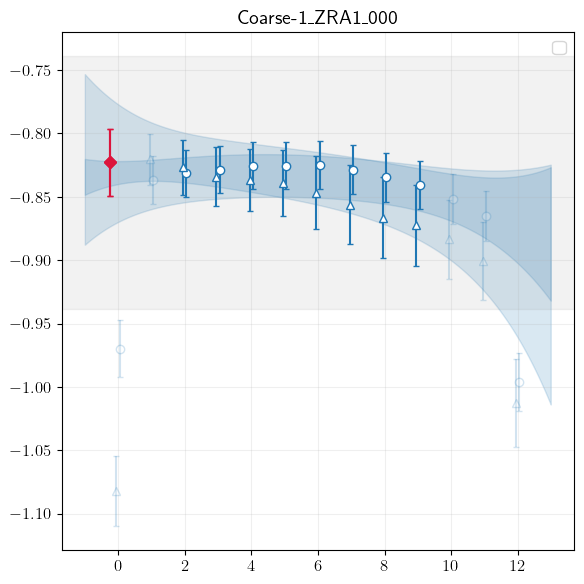

In [15]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

# f, ax = plt.subplots(1,1,figsize=(8,4))
f, ax = plt.subplots(1,1,figsize=(6,6))

robj.plot_fit(ax,NSTATES,trange)

f0 = pr['ratio'][0]
ax.axhspan(ymin=f0.mean-f0.sdev,ymax=f0.mean+f0.sdev,alpha=0.1,color='gray')

# ax.set_xlim(-0.5,18)
ax.grid(alpha=0.2)
ax.legend()
ax.set_title(f'{ENSEMBLE}_{RATIO}_{MOMENTUM}')
plt.tight_layout()
# plt.savefig('/Users/pietro/Desktop/bad_ratio.pdf')

# Model average for `Nstates` and trange

In [17]:
TIC = {}
for Nstates in [1,2,3]:
    dE_src = phys_energy_priors(ENSEMBLE,'Dst',MOMENTUM,Nstates,readfrom=DATA_2PT)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,MOMENTUM,Nstates,readfrom=DATA_2PT)
    x,ydata = robj.format(trange,flatten=True)
    f_0    = gv.gvar(np.mean(ydata).mean,0.05)
    pr = robj.priors(Nstates, K=f_0, dE_src=dE_src, dE_snk=dE_snk)

    for tmin in [1,2,3,4,5]:
        print(f'{Nstates=},{tmin=}')

        trange = (tmin, robj.Ta-tmin-1)

        fit = robj.fit(
            Nstates = Nstates,
            trange  = trange,
            priors  = pr,
            verbose = False,
            **cov_specs
        )

        res = robj.fit_result(
            Nexc   = Nstates,
            trange = trange,
            priors = pr,
            verbose = False
        )
        TIC[Nstates,trange] = float((res['chi2'] - 2*res['chiexp']))

Nstates=1,tmin=1
Nstates=1,tmin=2
Nstates=1,tmin=3
Nstates=1,tmin=4
Nstates=1,tmin=5
Nstates=2,tmin=1
Nstates=2,tmin=2
Nstates=2,tmin=3
Nstates=2,tmin=4
Nstates=2,tmin=5
Nstates=3,tmin=1
Nstates=3,tmin=2
Nstates=3,tmin=3
Nstates=3,tmin=4
Nstates=3,tmin=5


In [18]:
norm = np.exp(-np.array(list(TIC.values()))/2).sum()

vals = np.array([f.p['ratio'][0] for k,f in robj.fits.items()])
weig = np.array([np.exp(-TIC[k]/2)/norm for k in robj.fits]   )

stat = sum(vals * weig)
syst = np.sqrt(gv.mean(sum(weig*vals*vals) - (sum(weig*vals))**2))


print(stat,syst)

-0.845(27) 0.008827345704534967


Print the results

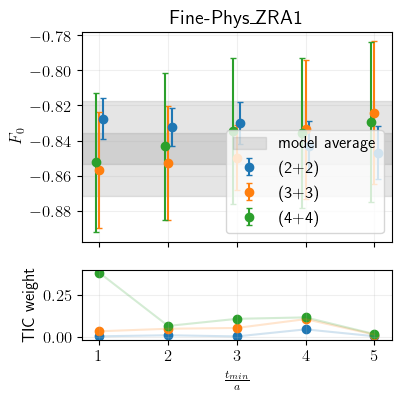

In [19]:
f, ax = plt.subplots(2,1,figsize=(4,4),gridspec_kw={'height_ratios': [3, 1]},sharex=True)

ts      = np.array([1,2,3,4,5])
tranges = [((t,robj.Ta-t-1)) for t in ts]

for i,n in enumerate([1,2,3]):
    f0 = [robj.fits[n,tr].p['ratio'][0] for tr in tranges]
    off = -0.05*i + 0.05
    ax[0].errorbar(ts+off,gv.mean(f0),gv.sdev(f0),fmt='o', color=f'C{i}', capsize=2.5, label=f'({n+1}+{n+1})')

    tic = [np.exp(-TIC[n,tr]/2)/norm for tr in tranges]
    ax[1].plot(ts,tic,alpha=0.2,color=f'C{i}')
    ax[1].scatter(ts,tic,marker='o',color=f'C{i}')

ax[0].axhspan(ymin=stat.mean-stat.sdev,ymax=stat.mean+stat.sdev,color='gray',alpha=0.2,label='model average')
ax[0].axhspan(ymin=stat.mean-syst,ymax=stat.mean+syst,color='gray',alpha=0.2)

ax[0].grid(alpha=0.2)
ax[0].legend(loc='lower right')
ax[0].set_ylabel(r'$F_0$')

ax[1].grid(alpha=0.2)
# ax[1].set_ylim(-0.1,1.1)
ax[1].set_ylabel(r'TIC weight')
ax[1].set_xlabel(r'$\frac{t_{min}}{a}$')

ax[0].set_title(f'{ENSEMBLE}_{RATIO}')
plt.savefig(f'/Users/pietro/Desktop/model_average_{ENSEMBLE}_{RATIO}_{MOMENTUM}.pdf')